## Create Random Points

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

In [55]:
roi = gpd.read_file('tehrant.shp')
roi.total_bounds

array([ 506999.4063, 3936167.    ,  554796.875 , 3965082.25  ])

In [56]:
minx, miny, maxx, maxy = roi.total_bounds 

In [57]:
def random_points_in_bound(minX, minY, maxX, maxY):
    x = np.random.uniform(minX, minY)
    y = np.random.uniform(minY, maxY)
    return Point(x,y)

In [58]:
numPoints = 100
randomPoints = []

In [59]:
while len(randomPoints) < numPoints:
    point = random_points_in_bound(minx,miny, maxx, maxy)
    if roi.contains(point).any():
        randomPoints.append(point)

<Axes: >

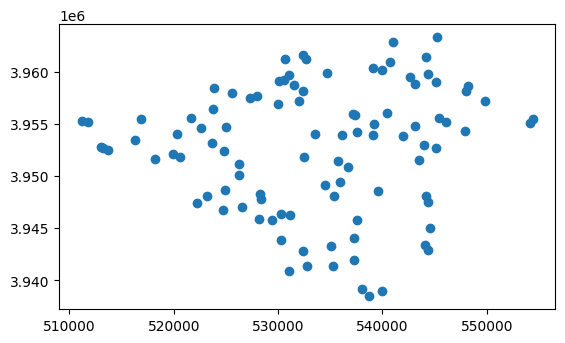

In [60]:
points_gdf = gpd.GeoDataFrame(geometry=randomPoints, crs=roi.crs)
points_gdf.plot()

## Getting Elevation and Weather data from API

In [61]:
import requests

BASE_URL = 'https://api.open-meteo.com/v1/forecast'

points_gdf = points_gdf.to_crs(epsg=4326)

for idx, point in points_gdf.iterrows():
    params = {
        'latitude': point.geometry.y,
        'longitude': point.geometry.x,
        'current': 'temperature_2m',
        'forecast_days': 1
    }    
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        jsonData = response.json()
        points_gdf.loc[idx, 'temperature'] = jsonData['current']['temperature_2m']
        points_gdf.loc[idx, 'elevation'] = jsonData['elevation']

In [62]:
points_gdf.head()

,geometry,temperature,elevation
0,POINT (51.45022 35.79155),12.7,1519.0
1,POINT (51.24516 35.6701),15.5,1163.0
2,POINT (51.50113 35.81279),10.9,1726.0
3,POINT (51.2902 35.70382),15.2,1224.0
4,POINT (51.34336 35.78068),12.4,1566.0


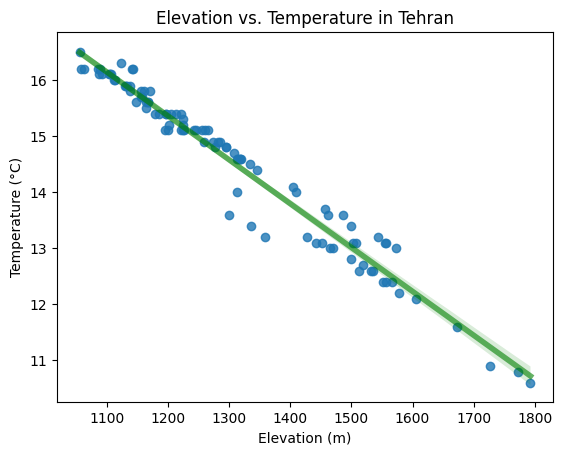

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(data=points_gdf, x='elevation', y='temperature', line_kws={"color":"green","alpha":0.6,"lw":4})
plt.title('Elevation vs. Temperature in Tehran')
plt.xlabel('Elevation (m)')
plt.ylabel('Temperature (°C)')
plt.show()

Tiles:
"OpenStreetMap" (default)
"Stamen Terrain"
"Stamen Toner"
"Stamen Watercolor"
"CartoDB positron"
"CartoDB dark_matter"

In [71]:
import folium
from folium.plugins import MiniMap, HeatMap

# Create a base map centered on Tehran
map = folium.Map(location=[35.6892, 51.3890], zoom_start=11)

# Add markers for each location with temperature and elevation info
for idx, point in points_gdf.iterrows():
    popup_info = f"Point({round(point.geometry.y, 2)},{round(point.geometry.x,2)}): {point['temperature']}°C, {point['elevation']}m"
    color = 'red' if point['temperature'] > 15 else 'blue'  # Color based on temperature
    folium.Marker(
        location=[point.geometry.y, point.geometry.x],
        popup=popup_info,
        icon=folium.Icon(color=color)
    ).add_to(map)

folium.TileLayer("CartoDB dark_matter", attr="CartoDB dark_matter", name='CartoDB dark_matter').add_to(map)
folium.TileLayer("CartoDB positron", attr="CartoDB positron", name="CartoDB positron").add_to(map)

# Add LayerControl to toggle between tiles
folium.LayerControl().add_to(map) 
minimap = MiniMap(toggle_display=True)
map.add_child(minimap)
# Save the map to an HTML file
map.save('tehran_elevation_temperature_map.html')

In [13]:
import pandas as pd
import geopandas as gpd

df = pd.read_csv('query.csv')
df['time_objects'] = pd.to_datetime(df['time'], format="%Y-%m-%dT%H:%M:%S.%fZ")
df['year'] = df['time_objects'].dt.year
df['month'] = df['time_objects'].dt.month

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude)
)

gdf.crs = 'epsg:4326'

In [14]:
gdf.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,depthError,magError,magNst,status,locationSource,magSource,time_objects,year,month,geometry
0,2024-10-01T07:12:36.190Z,18.0206,-66.7601,16.000,3.39,md,19.0,140.0,0.1889,0.24,...,0.880,0.100,15.0,reviewed,pr,pr,2024-10-01 07:12:36.190,2024,10,POINT (-66.7601 18.0206)
1,2024-10-01T07:10:38.587Z,0.4903,122.2921,121.587,5.00,mb,63.0,59.0,1.5960,0.85,...,5.419,0.069,68.0,reviewed,us,us,2024-10-01 07:10:38.587,2024,10,POINT (122.2921 0.4903)
2,2024-10-01T05:52:49.980Z,31.4537,132.4060,15.014,4.60,mb,28.0,129.0,1.6700,0.65,...,4.752,0.112,24.0,reviewed,us,us,2024-10-01 05:52:49.980,2024,10,POINT (132.406 31.4537)
3,2024-10-01T05:01:57.237Z,-20.1953,-70.6982,21.903,5.30,mww,77.0,109.0,0.5380,0.94,...,2.814,0.066,22.0,reviewed,us,us,2024-10-01 05:01:57.237,2024,10,POINT (-70.6982 -20.1953)
4,2024-10-01T04:49:40.385Z,-41.5796,174.3163,19.569,4.60,mb,31.0,65.0,0.3980,0.93,...,4.524,0.141,15.0,reviewed,us,us,2024-10-01 04:49:40.385,2024,10,POINT (174.3163 -41.5796)


In [15]:
from folium.plugins import MarkerCluster, HeatMap
import folium


m = folium.Map(location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()], zoom_start=3)

# 1. Add a marker cluster
marker_cluster = MarkerCluster().add_to(m)
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=(f"<strong>Location:</strong> {row['place']}<br>"
               f"<strong>Time:</strong> {row['time']}<br>"
               f"<strong>Magnitude:</strong> {row['mag']}<br>"
               f"<strong>Depth:</strong> {row['depth']} km"),
        icon=folium.Icon(color="red" if row['mag'] >= 5 else "orange", icon="info-sign")
    ).add_to(marker_cluster)

# 2. Add a heatmap for earthquake density
heat_data = [[row.geometry.y, row.geometry.x] for _, row in gdf.iterrows() if row['mag'] >= 4]
HeatMap(heat_data, radius=15).add_to(m)

# 3. Add a custom layer control
folium.LayerControl().add_to(m)

m

In [4]:
import folium
from folium.plugins import TimestampedGeoJson, LocateControl
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load and preprocess data
df = pd.read_csv('query.csv')
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%dT%H:%M:%S.%fZ")

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# Prepare GeoJSON data with timestamp property
features = []
for _, row in gdf.iterrows():
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [row.geometry.x, row.geometry.y],
        },
        "properties": {
            "time": row['time'].isoformat(),
            "magnitude": row['mag'],
            "depth": row['depth'],
            "style": {
                "color": "red" if row['mag'] >= 3 else "blue",
                "radius": row['mag'] * 2,
                "fillOpacity": 0.6
            }
        }
    }
    features.append(feature)

# Convert the data to GeoJSON format
geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

# Create the map
m = folium.Map(location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()], zoom_start=2)

# Add the TimestampedGeoJson layer for time slider
TimestampedGeoJson(
    data=geojson_data,
    transition_time=200,  # Adjust speed of transition
    loop=False,  # Loop the time slider
    auto_play=False,  # Auto start the slider
    add_last_point=True,  # Keep the last point
    period="PT6H"  # Time period for each timestamp (adjust as needed)
).add_to(m)
LocateControl().add_to(m)
# Save the map to an HTML file
m.save("time_slider_map.html")
